In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 10.0.0.10001044
-- The CXX compiler identification is AppleClang 10.0.0.10001044
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /Users/dario/anaconda3/envs/metodos/bin/python (found version "3.6.5") 
-- Found PythonLibs: /Users/dario/anaconda3/envs/metodos/lib/libpython3.6m.dylib
-- pybind11 v2.2.

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/Users/dario/Projects/MetNum-1C2020/tp2/notebooks
Python 3.6.5 :: Anaconda, Inc.


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

## Genero los archivos de pruebas

Acá vamos a generar como hablamos con Nicolas los archivos de prueba del training set. Vamos a agarrar por un tema de scope y tiempos 3 grupos de pruebas. Vamos a agarrar y experimentar con el 50%, 70% y 90% del training set y vamos a guardarnos el último 10% del set para test de accuracy y kappa cohen.

In [4]:
import os

In [5]:
def get_training_data(percentage, percentage_test):
    df = pd.read_csv("../data/train.csv")

    offset      = (df.shape[0]*percentage)//100
    offset_test = (df.shape[0]*percentage_test)//100
    # primeros offset para entrenar
    df_train    = df[:offset]
    # ultimos offset_test para testear
    df_test     = df[df.shape[0]-offset_test:]

    y_train = df_train['label']
    X_train = df_train.drop(columns=['label'])

    y_test  = df_test['label']
    X_test  = df_test.drop(columns=['label'])
    
    return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}


In [6]:
# 50% del training set y el ultimo 10% para testear
df_50 = get_training_data(50, 10)

# 70% del training set y el ultimo 10% para testear
df_70 = get_training_data(70, 10)

# 90% del training set y el ultimo 10% para testear
df_90 = get_training_data(90, 10)

### Cual es el balance de numeros de entrenamiento

In [7]:
df_50['y_train'].value_counts(normalize=True)

1    0.112952
3    0.103667
7    0.103190
2    0.100381
9    0.099000
6    0.098810
4    0.098810
0    0.097333
8    0.095476
5    0.090381
Name: label, dtype: float64

### Cual es el balance de numeros de testeo

In [8]:
df_50['y_test'].value_counts(normalize=True)

1    0.109048
0    0.108333
3    0.106667
4    0.104286
9    0.100952
7    0.100238
6    0.098333
8    0.094524
2    0.093333
5    0.084286
Name: label, dtype: float64

### Prueba de calificación KNN

Acá solo comprobamos que ande la librería y comparamos que nos de algo similar a la librería de sklearn

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [10]:
%%time
clf = metnum.KNNClassifier(3)

clf.fit(df_50['X_train'], df_50['y_train'])
y_pred = clf.predict(df_50['X_test'])

acc = accuracy_score(df_50['y_test'], y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.9619047619047619
CPU times: user 1min 8s, sys: 1.63 s, total: 1min 10s
Wall time: 1min 16s


In [11]:
%%time
clf = KNeighborsClassifier(3)

clf.fit(df_50['X_train'], df_50['y_train'])
y_pred = clf.predict(df_50['X_test'])

acc = accuracy_score(df_50['y_test'], y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.9619047619047619
CPU times: user 2min 43s, sys: 2.01 s, total: 2min 45s
Wall time: 3min


### KNN + PCA

In [12]:
clf_pca = metnum.PCA(10)
clf_pca.fit(df_50['X_train'])

X_train_pca = clf_pca.transform(df_50['X_train'])
X_test_pca = clf_pca.transform(df_50['X_test'])

In [13]:
clf_pca = metnum.KNNClassifier(3)
clf_pca.fit(X_train_pca, df_50['y_train'])

In [14]:
%%time
y_pred = clf_pca.predict(X_test_pca)

acc = accuracy_score(df_50['y_test'], y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.9178571428571428
CPU times: user 10.1 s, sys: 693 ms, total: 10.8 s
Wall time: 11.7 s


# Aca empezamos los graficos para el informe

## Ahora probemos accuracy y kappa cohen para muchos k de KNN

Aquí las pruebas se harán con la base de 50% de training y el ultimo 10% para test.

In [7]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [8]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import metnum

Una vez que se corre un predict, todas las distancias quedan guardadas entonces con la función predictWithK podemos ver el resultado para KNN pero con el k especifico que le pasemos al llamarlo. Esto se hizo para poder experimentar rapido con una gran cantidad de k distintos.

Ahora vamos a probar el accuracy y el kappa para 2mil k distintos y ver como varia la calidad del resultado

In [9]:
def knn_curva_completa(data, kstart=2, kend=1300, kstep=2):
    clf = metnum.KNNClassifier(3)

    clf.fit(data['X_train'], data['y_train'])
    y_pred = clf.predict(data['X_test'])

    knn_values = {'accuracy':[], 'kappa': []}
    for _k in range(kstart, kend, kstep):
        y_pred = clf.predictWithK(_k)
        knn_values['accuracy'].append(accuracy_score(data['y_test'], y_pred))
        knn_values['kappa'].append(cohen_kappa_score(data['y_test'], y_pred))
    
    return pd.DataFrame(knn_values)

In [10]:
%%time
df_knn_50 = knn_curva_completa(df_50, 1, 1300, 2)

CPU times: user 2min 54s, sys: 4.66 s, total: 2min 59s
Wall time: 3min 1s


In [81]:
print("Maximo accuracy", np.max(df_knn_50['accuracy']))
print("Maximo kappa", np.max(df_knn_50['kappa']))

Maximo accuracy 0.9619047619047619
Maximo kappa 0.9576383373047392


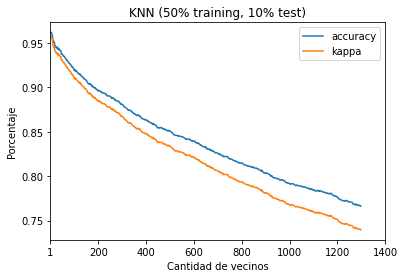

In [11]:
df_knn_50.plot()
plt.title("KNN (50% training, 10% test)")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(1, loc[-1]*2, len(loc), dtype=int))

In [12]:
%%time
df_knn_70 = knn_curva_completa(df_70, 1, 1300, 2)

CPU times: user 3min 50s, sys: 5.44 s, total: 3min 56s
Wall time: 3min 57s


In [82]:
print("Maximo accuracy", np.max(df_knn_70['accuracy']))
print("Maximo kappa", np.max(df_knn_70['kappa']))

Maximo accuracy 0.9669047619047619
Maximo kappa 0.9632029378149188


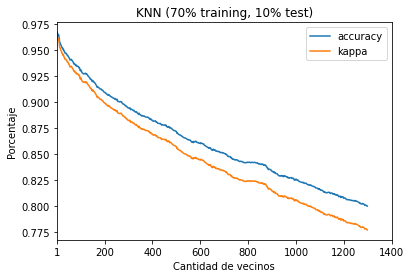

In [13]:
df_knn_70.plot()
plt.title("KNN (70% training, 10% test)")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(1, loc[-1]*2, len(loc), dtype=int))

In [14]:
%%time
df_knn_90 = knn_curva_completa(df_90, 1, 1300, 2)

CPU times: user 4min 44s, sys: 6.85 s, total: 4min 51s
Wall time: 4min 55s


In [83]:
print("Maximo accuracy", np.max(df_knn_90['accuracy']))
print("Maximo kappa", np.max(df_knn_90['kappa']))

Maximo accuracy 0.9688095238095238
Maximo kappa 0.9653212395936144


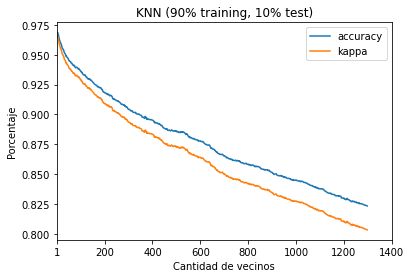

In [15]:
df_knn_90.plot()
plt.title("KNN (90% training, 10% test)")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(1, loc[-1]*2, len(loc), dtype=int))

En todas los tamaños de traing KNN empeora el accuracy y el coeficiente kappa cohen  empeoran a medida que tomamos más cantidad de vecinos (k mas grande). A partir de acá empezaremos a evaluar solo los K entre 0 y 600 que es el valor de K donde la baja es más brusca en el test de 50% training.

In [29]:
df_accuracy_todos = pd.DataFrame({'Entrenamiento 90%': list(df_knn_90['accuracy']), 'Entrenamiento 70%': list(df_knn_70['accuracy']), 'Entrenamiento 50%': list(df_knn_50['accuracy'])})
df_kappa_todos = pd.DataFrame({'Entrenamiento 90%': list(df_knn_90['kappa']), 'Entrenamiento 70%': list(df_knn_70['kappa']), 'Entrenamiento 50%': list(df_knn_50['kappa'])})

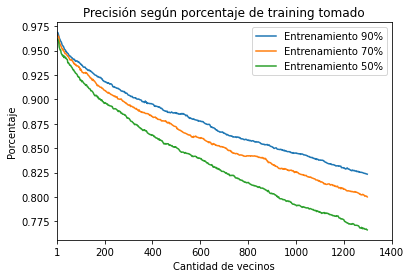

In [31]:
df_accuracy_todos.plot()
plt.title("Precisión según porcentaje de training tomado")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(1, loc[-1]*2, len(loc), dtype=int))

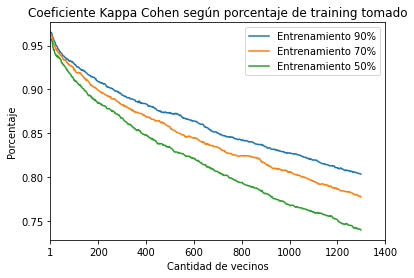

In [32]:
df_kappa_todos.plot()
plt.title("Coeficiente Kappa Cohen según porcentaje de training tomado")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(1, loc[-1]*2, len(loc), dtype=int))

#### Acotamos a 100 k para ver en detalle como se comportan en el mejor lugar

In [25]:
df_knn_50_acotado = knn_curva_completa(df_50, 1, 30, 1)
df_knn_70_acotado = knn_curva_completa(df_70, 1, 30, 1)
df_knn_90_acotado = knn_curva_completa(df_90, 1, 30, 1)



In [26]:
df_accuracy_todos_acotado = pd.DataFrame({'Entrenamiento 90%': list(df_knn_90_acotado['accuracy']), 'Entrenamiento 70%': list(df_knn_70_acotado['accuracy']), 'Entrenamiento 50%': list(df_knn_50_acotado['accuracy'])})
df_kappa_todos_acotado = pd.DataFrame({'Entrenamiento 90%': list(df_knn_90_acotado['kappa']), 'Entrenamiento 70%': list(df_knn_70_acotado['kappa']), 'Entrenamiento 50%': list(df_knn_50_acotado['kappa'])})

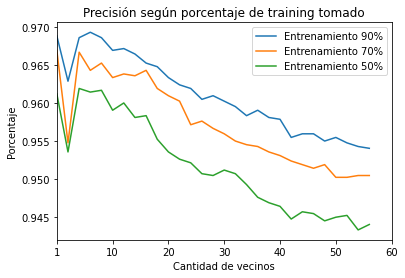

In [27]:
df_accuracy_todos_acotado.plot()
plt.title("Precisión según porcentaje de training tomado")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(1, loc[-1]*2, len(loc), dtype=int))

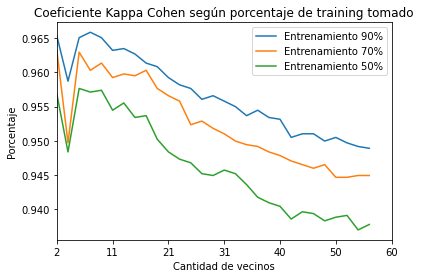

In [28]:
df_kappa_todos_acotado.plot()
plt.title("Coeficiente Kappa Cohen según porcentaje de training tomado")
plt.ylabel("Porcentaje")
plt.xlabel("Cantidad de vecinos")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(2, loc[-1]*2, len(loc), dtype=int))

# heatmap de las corridas

## primero 50% training set, 10% test

In [27]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [35]:
log_files = []
for root, dirs, files in os.walk("../data/tests/"):
    for filename in files:
        if 'beta' in filename:
            log_files.append(root + '/' + filename)


In [36]:
%%time
def getMetrics(files_names, log_name):
    files = [f for f in log_files if log_name in f]
    metrics = {}
    for f in files[:]:
        alpha = int(f.split('_')[-1][4:])
        data = pd.read_csv(f, index_col=0)
        metrics[alpha] = data
    return metrics

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11 µs


In [37]:
def getDataFromMetrics(metrics):
    beta_cantidad = len(metrics.keys())
    random_key = list(metrics.keys())[0]
    k_cantidad = len(metrics[ random_key ])

    data = {
        'accuracy': np.zeros(shape=(k_cantidad, beta_cantidad), dtype=np.float64),
        'kappa_cohen': np.zeros(shape=(k_cantidad, beta_cantidad), dtype=np.float64),
        'betas': list(metrics.keys()),
        'all_ks': metrics[random_key].index,
    }
    data['betas'].sort()
    
    for akey, beta in enumerate(data['betas']):
        for kkey, k in enumerate(metrics[beta].index):
            row_data = metrics[beta].iloc[kkey,:]
            try:
                data['kappa_cohen'][kkey, akey] = row_data['kappa_cohen']
                data['accuracy'][kkey, akey] = row_data['accuracy']
            except:
                pass
    
    return data

In [38]:
test_50_percent = getMetrics(log_files, '50_percent')
data_50 = getDataFromMetrics(test_50_percent)

In [39]:
def heatmap(title, accuracy, all_ks, betas, vmin=None, vmax=None):
    figure = plt.figure(figsize=(20,10))

    sns.set()
    sns.set_context("paper")

    df = pd.DataFrame(accuracy, index=all_ks, columns=betas)
    ax2 = sns.heatmap(df, vmin=vmin, vmax=vmax)
    ax2.set_title(title, {'fontsize':20})
    ax2.set_xlabel("PCA", {'fontsize':15})
    ax2.set_ylabel("kNN", {'fontsize':15})

    plt.show()
    plt.close()

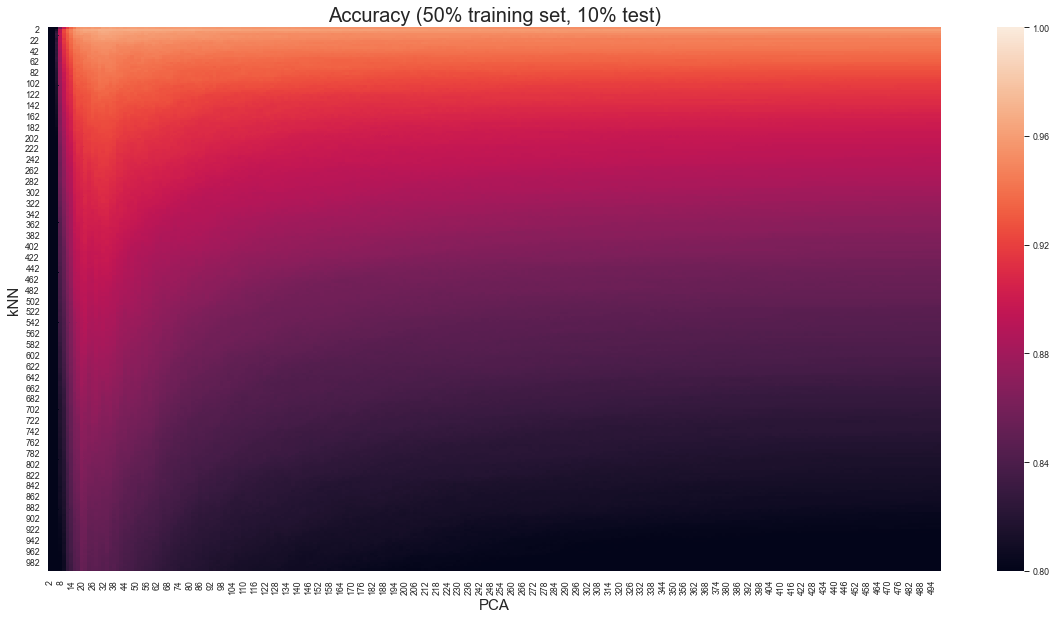

In [40]:
heatmap("Accuracy (50% training set, 10% test)",
                 data_50['accuracy'],
                 data_50['all_ks'],
                 data_50['betas'],
                 vmin=0.8,
                 vmax=1.0
                )

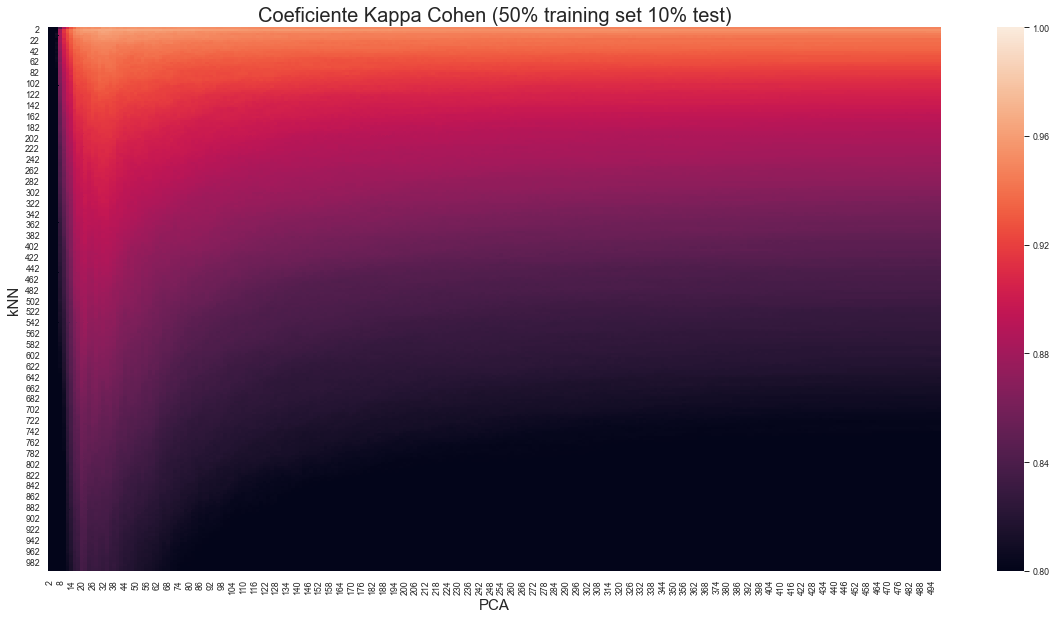

In [41]:
heatmap("Coeficiente Kappa Cohen (50% training set 10% test)",
                 data_50['kappa_cohen'],
                 data_50['all_ks'],
                 data_50['betas'],
                 vmin=0.8,
                 vmax=1.0
                )

In [42]:
def heatmap_verticales(title, accuracy, kappa_cohen, all_ks, betas, vmin=None, vmax=None):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,10))

    fig.suptitle(title, fontsize=20)
    fig.text(0.5, 0.08, 'PCA', ha='center', fontdict={'fontsize':15})
    fig.text(0.08, 0.5, 'kNN', va='center', rotation='vertical', fontdict={'fontsize':15})

    sns.set()
    sns.set_context("paper")

    
    df_accu  = pd.DataFrame(accuracy,    index=all_ks, columns=betas)
    df_kappa = pd.DataFrame(kappa_cohen, index=all_ks, columns=betas)

    ax1 = sns.heatmap(df_accu,  vmin=vmin, vmax=vmax, ax=ax1)
    ax1.set_title("Accuracy", {'fontsize':20})

    ax2 = sns.heatmap(df_kappa, vmin=vmin, vmax=vmax, ax=ax2)#, vmax=0.61)
    ax2.set_title("Kappa Cohen", {'fontsize':20})

    plt.show()
    plt.close()


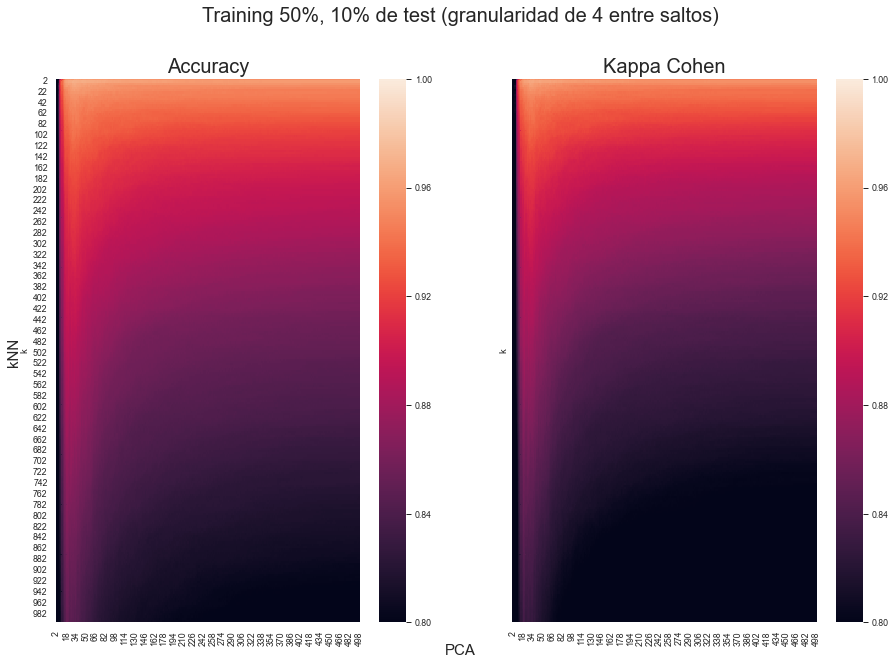

In [43]:
heatmap_verticales("Training 50%, 10% de test (granularidad de 4 entre saltos)",
                 data_50['accuracy'],
                 data_50['kappa_cohen'],
                 data_50['all_ks'],
                 data_50['betas'],
                 vmin=0.8,
                 vmax=1.0
                )

## 70% training set, 10% test

In [44]:
test_70_percent = getMetrics(log_files, '70_percent')

In [45]:
data_70 = getDataFromMetrics(test_70_percent)

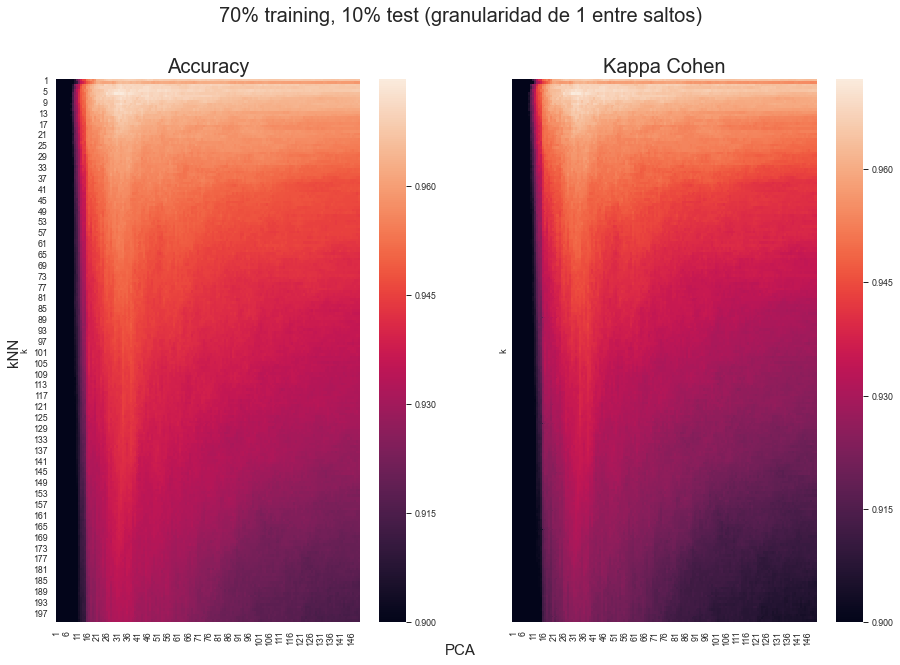

In [46]:
heatmap_verticales("70% training, 10% test (granularidad de 1 entre saltos)",
                        data_70['accuracy'],
                        data_70['kappa_cohen'],
                        data_70['all_ks'],
                        data_70['betas'],
                        vmin=.9,
                        vmax=None
                  )

## 70% training set, 10% test

In [47]:
test_90_percent = getMetrics(log_files, '90_percent')
data_90 = getDataFromMetrics(test_90_percent)

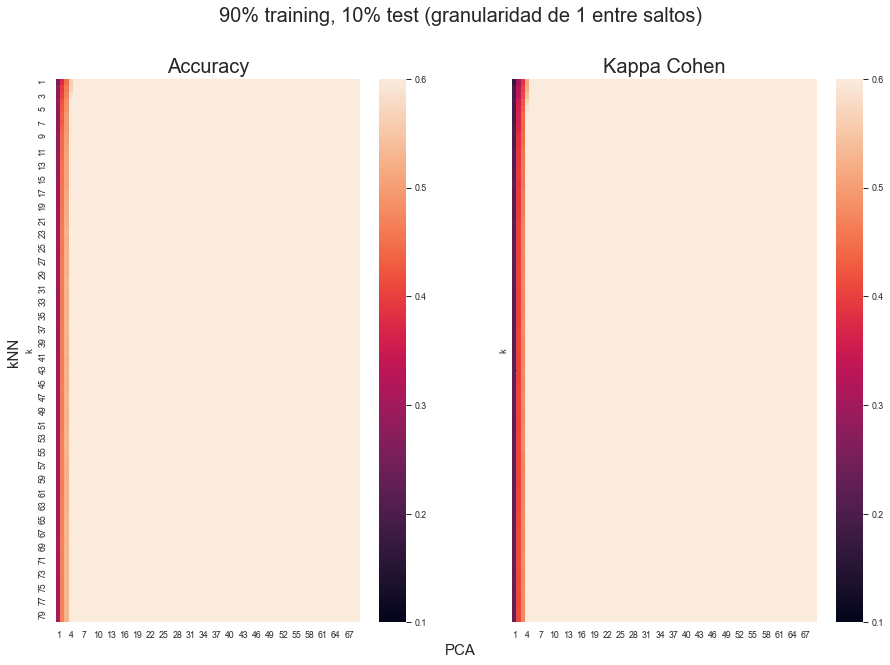

In [67]:
heatmap_verticales("90% training, 10% test (granularidad de 1 entre saltos)",
                        data_90['accuracy'],
                        data_90['kappa_cohen'],
                        data_90['all_ks'],
                        data_90['betas'],
                        vmin=.1,
                        vmax=.6
                  )

In [85]:
maximo = np.max(data_90['accuracy'])
print('Maximo accuracy', maximo)
for i in range(data_90['accuracy'].shape[0]):
    for j in range(data_90['accuracy'].shape[1]):
        if abs(maximo - data_90['accuracy'][i][j]) < 1e-3:
            print("k", i+1, ", alpha", j+1)


Maximo accuracy 0.9761904761904762
k 4 , alpha 27
k 4 , alpha 40
k 4 , alpha 45
k 4 , alpha 47
k 4 , alpha 48
k 5 , alpha 51
k 5 , alpha 54
k 5 , alpha 55
k 5 , alpha 56


In [80]:
maximo = np.max(data_90['kappa_cohen'])
print('Maximo kappa cohen', maximo)
for i in range(data_90['kappa_cohen'].shape[0]):
    for j in range(data_90['kappa_cohen'].shape[1]):
        if abs(maximo - data_90['kappa_cohen'][i][j]) < 1e-3:
            print("k", i+1, ", alpha", j+1)

Maximo kappa cohen 0.9735271982825456
k 4 , alpha 40
k 4 , alpha 45
k 4 , alpha 47
k 5 , alpha 51
